In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score # for measuring model
from collections import Counter

In [2]:
## From Week 3 code to train the model

# df = pd.read_csv('data-week-3.csv')
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv", sep = ",")

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [3]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [4]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [5]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(max_iter = 10000)
# model = LogisticRegression(solver='lbfgs', max_iter = 1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [6]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

In [7]:
## 4.2 Accuracy and dummy model

In [8]:
len(y_val)

1409

In [9]:
# correct predictions
(y_val == churn_decision).sum()

np.int64(1132)

In [10]:
# correct preductinos/ length of y_val
1132/1409

0.8034066713981547

In [11]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [27]:
# play with different thresholds to see which is the most accurate
#linspace(first value, last value, array size)

thresholds = np.linspace(0, 1, 21)

# list to populate with threshold results
scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    #score = (y_val == churn_decision).mean()
    score = accuracy_score(y_val, y_pred >= t) # does the same as the line above
    print ('%.2f %.3f' % (t, score)) # threshold 2 dec places, score is with 3 decimal places
    scores.append(score)

    # note for 1, assuming everyone churns, the accuracy is 72.6%. For 0.5 the accuracy is 80%.
    # Is it worth building a model for just 7% increase in accuracy?

0.00 0.274
0.05 0.513
0.10 0.608
0.15 0.661
0.20 0.703
0.25 0.734
0.30 0.758
0.35 0.765
0.40 0.782
0.45 0.791
0.50 0.803
0.55 0.801
0.60 0.796
0.65 0.789
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


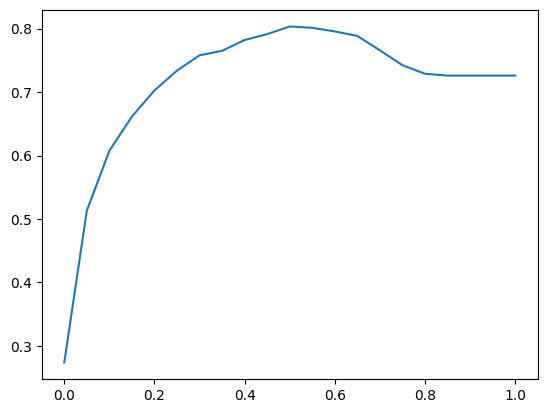

In [28]:

# plotting the scores
plt.plot(thresholds, scores)

In [68]:
# checking how many are true/ false. all False in this case
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

In [30]:
## Class imbalance?

In [69]:
1 - y_val.mean()

np.float64(0.7260468417317246)

1 - y_val.mean()

In [31]:
## 4.3 Confusion table

In [70]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [71]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [72]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [73]:
# look at first 5 records to verify
# comparing predicted and actual positive.
predict_positive[:5]

array([False, False, False,  True, False])

In [74]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[920, 103],
       [174, 212]])

In [75]:
# change to percents so you can see the proportion
(confusion_matrix / confusion_matrix.sum()).round(2) 

array([[0.65, 0.07],
       [0.12, 0.15]])

In [39]:
## Precision and Recall
# Precision - what fraction of positive predictions are correct? eg. of all the predicted chur, how many were correc? tp and fp
# Recall - fraction of correctly identified positive examples. eg. of all the churned, how many were caught? tp and fn

In [78]:
(tp + tn) / (tn + tp + fn + fp)

np.float64(0.8034066713981547)

In [79]:
# precision
p = tp/ (tp + fp)
p

np.float64(0.6730158730158731)

In [80]:
#recall
r = tp/ (tp + fn)
r

np.float64(0.5492227979274611)

In [81]:
## ROC Curves

In [83]:
#TPR and FRP
# Part of ROC Curves
tpr = tp / (tp + fn)
tpr

np.float64(0.5492227979274611)

In [84]:
fpr = fp / (fp + tn)
fpr

np.float64(0.10068426197458455)

In [95]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_positive).sum()

    fp = (predict_positive & actual_positive).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [96]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns = columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [97]:
df_scores.fn

0        0
1        1
2        3
3        4
4        4
      ... 
96     386
97     386
98     386
99     386
100    386
Name: fn, Length: 101, dtype: int64

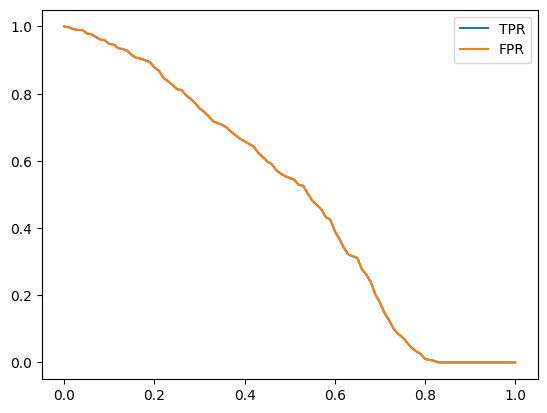

In [98]:
plt.plot(df_scores.threshold, df_scores['tpr'], label= 'TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label = 'FPR')
plt.legend()

In [57]:
# Random Model
# Part of ROC curves

In [58]:
np.random.seed(1)
y_rand = np.random.uniform(0,1, size = len(y_val))

In [59]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [60]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predic_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'tn', 'fn']

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [61]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

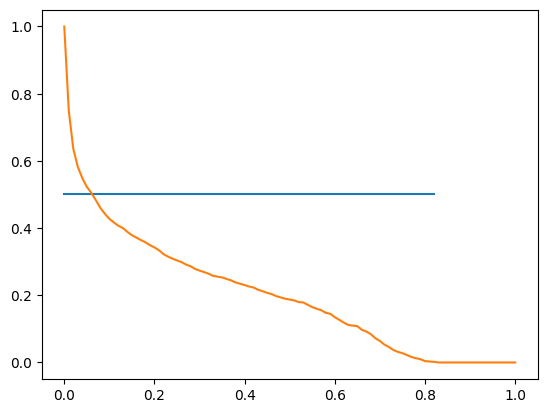

In [62]:
plt.plot(df_rand.threshold, df_rand['tpr'], label = 'TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label = 'FPR')
plt.legend